In [872]:
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from download_wb_data import download_wb_data, download_cat_info
from lib_gather_data import get_country_name_dicts, df_to_iso3
from wb_api_wrapper import *

import warnings
warnings.filterwarnings("ignore")

In [873]:
root_dir = "./"
any_to_wb, iso3_to_wb, iso2_iso3 = get_country_name_dicts(root_dir)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs


In [874]:
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 100)

# Data Gathering

### Data sources to be included:

World Bank: 
* GDP per capita (PPP)
* Government Effectiveness
* Remittances as share of GDP
* WB country classification
* Gini index

ILO:
* Total expenditure on social protection (excluding health)
* Domestic general government health expenditure
* Pension coverage
* Social protection coverage
* Health coverage

Other:
* Indicator for former socialist countries

In [875]:
gdp_pc = get_wb_series('NY.GDP.PCAP.PP.KD', 'gdp_pc').dropna().astype(float).to_frame().reset_index()
gdp_pc = gdp_pc.loc[gdp_pc.groupby('country').year.idxmax()].drop('year', axis=1)
gdp_pc = df_to_iso3(gdp_pc, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gdp_pc)

            gdp_pc
iso3              
AFG    1516.273265
ALB   15492.067404
DZA   11198.233483
AGO    5906.115677
ATG   22321.870019
...            ...
VUT    2785.903860
VNM   11396.531305
PSE    5722.409175
ZMB    3365.873780
ZWE    2207.957033

[194 rows x 1 columns]


array([[<Axes: title={'center': 'gdp_pc'}>]], dtype=object)

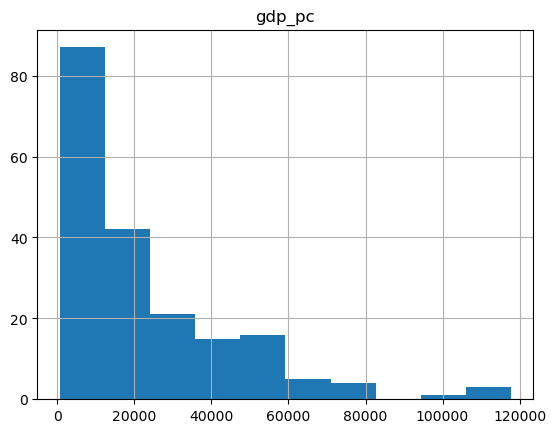

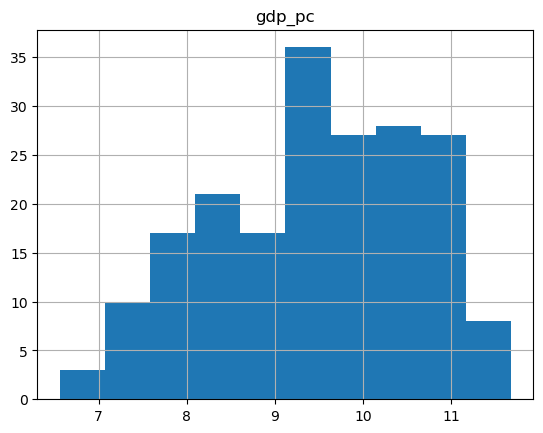

In [876]:
gdp_pc.hist()
(np.log(gdp_pc)).hist()

In [877]:
gvt_effectiveness = get_wb_series('GE.EST', 'GE_EST').dropna().astype(float).to_frame().reset_index()
gvt_effectiveness = gvt_effectiveness.loc[gvt_effectiveness.groupby('country').year.idxmax()].drop('year', axis=1)
gvt_effectiveness = df_to_iso3(gvt_effectiveness, 'country', any_to_wb).set_index('iso3', drop=True).drop('country', axis=1)
print(gvt_effectiveness)

        GE_EST
iso3          
AFG  -1.879552
ALB   0.065063
DZA  -0.513090
ASM   0.667918
AND   1.495305
...        ...
VIR   0.667918
PSE  -0.900953
YEM  -2.232542
ZMB  -0.658233
ZWE  -1.254613

[205 rows x 1 columns]


array([[<Axes: title={'center': 'GE_EST'}>]], dtype=object)

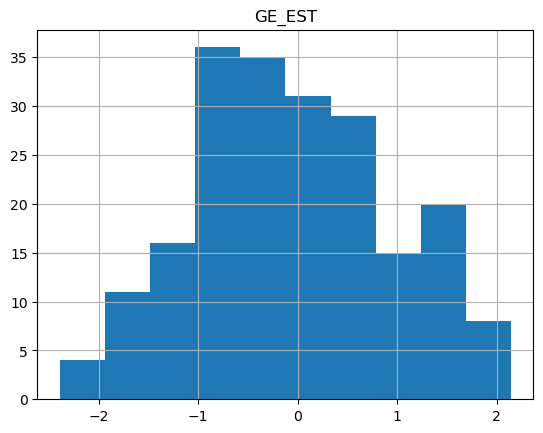

In [878]:
gvt_effectiveness.hist()

In [879]:
remittances = get_wb_series('BX.TRF.PWKR.DT.GD.ZS', 'remittances_gdp').dropna().astype(float).to_frame().reset_index()
remittances = remittances.loc[remittances.groupby('country').year.idxmax()].drop('year', axis=1)
remittances = df_to_iso3(remittances, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(remittances)

      remittances_gdp
iso3                 
AFG          2.102828
ALB          9.226106
DZA          0.902738
AND          1.593959
AGO          0.013116
...               ...
VNM          3.216862
PSE         21.186165
YEM         17.209770
ZMB          0.834892
ZWE         11.273013

[196 rows x 1 columns]


array([[<Axes: title={'center': 'remittances_gdp'}>]], dtype=object)

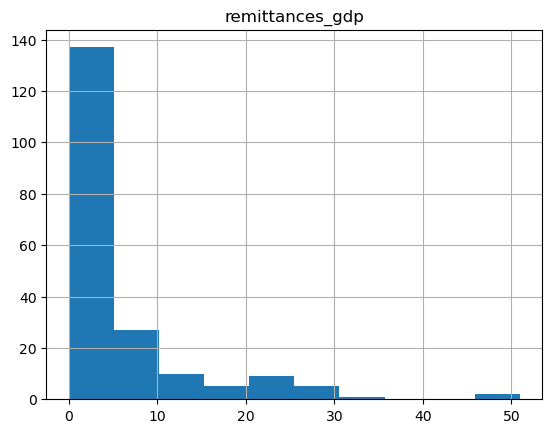

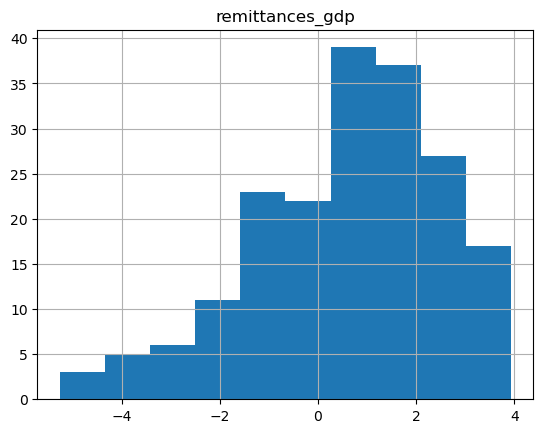

In [880]:
remittances.hist()
np.log(remittances[remittances > 0]).hist()

In [881]:
wb_country_classification = pd.read_excel("./inputs/WB_country_classification/country_classification.xlsx")[['Economy', 'Region', 'Income group']]
wb_country_classification.rename(columns={'Economy': 'country', 'Region': 'region', 'Income group': 'income_group'}, inplace=True)
wb_country_classification.set_index('country', inplace=True)
wb_country_classification.loc['Venezuela, RB', 'income_group'] = 'Upper middle income'
wb_country_classification.dropna(inplace=True)
wb_country_classification = df_to_iso3(wb_country_classification.reset_index(), 'country', any_to_wb).dropna().set_index('iso3').drop('country', axis=1)
for r in wb_country_classification['region'].unique():
    wb_country_classification[r.replace('&', '').replace('  ', ' ').replace(' ', '_').replace('-', '_')] = wb_country_classification['region'] == r
for ig in wb_country_classification['income_group'].unique():
    wb_country_classification[ig.replace(' ', '_')] = wb_country_classification['income_group'] == ig
print(wb_country_classification)

                          region         income_group  Latin_America_Caribbean  South_Asia  Sub_Saharan_Africa  Europe_Central_Asia  \
iso3                                                                                                                                  
ABW    Latin America & Caribbean          High income                     True       False               False                False   
AFG                   South Asia           Low income                    False        True               False                False   
AGO           Sub-Saharan Africa  Lower middle income                    False       False                True                False   
ALB        Europe & Central Asia  Upper middle income                    False       False               False                 True   
AND        Europe & Central Asia          High income                    False       False               False                 True   
...                          ...                  ...  

In [882]:
gini_index = get_wb_series('SI.POV.GINI', 'gini_index').dropna().astype(float).to_frame().reset_index()
gini_index = gini_index.loc[gini_index.groupby('country').year.idxmax()].drop('year', axis=1)
gini_index = df_to_iso3(gini_index, 'country', any_to_wb).dropna(subset='iso3').set_index('iso3', drop=True).drop('country', axis=1)
print(gini_index)

      gini_index
iso3            
ALB         29.4
DZA         27.6
AGO         51.3
ARG         42.0
ARM         27.9
...          ...
VNM         36.8
PSE         33.7
YEM         36.7
ZMB         55.9
ZWE         50.3

[162 rows x 1 columns]


array([[<Axes: title={'center': 'gini_index'}>]], dtype=object)

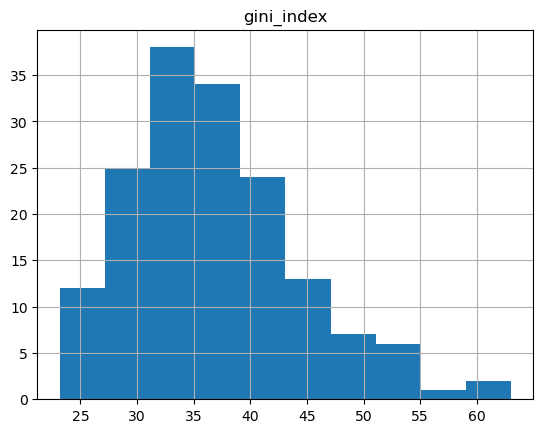

In [883]:
gini_index.hist()

In [884]:
ILO_A4_3 = pd.read_excel("./inputs/social_share_regression/ILO/tableA4.3_data.xlsx", na_values=['…', '...'])
ILO_A4_3 = df_to_iso3(ILO_A4_3, 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
social_prot_expenditure = (ILO_A4_3['Total expenditure on social protection (excluding health)'].astype(float) / 100).dropna().squeeze().rename('ILO_social_expenditure')
health_expenditure = (ILO_A4_3['Domestic general government health expenditure (GGHE-D), WHO'].astype(float) / 100).dropna().squeeze().rename('ILO_health_expenditure')
print(social_prot_expenditure)
print(health_expenditure)

iso3
DZA    0.089
EGY    0.095
LBY    0.044
MAR    0.045
SDN    0.007
       ...  
SVN    0.167
ESP    0.168
SWE    0.195
CHE    0.128
GBR    0.151
Name: ILO_social_expenditure, Length: 185, dtype: float64
iso3
DZA    0.041
EGY    0.014
MAR    0.021
SDN    0.010
TUN    0.042
       ...  
SVN    0.060
ESP    0.063
SWE    0.093
CHE    0.037
GBR    0.079
Name: ILO_health_expenditure, Length: 188, dtype: float64


<Axes: >

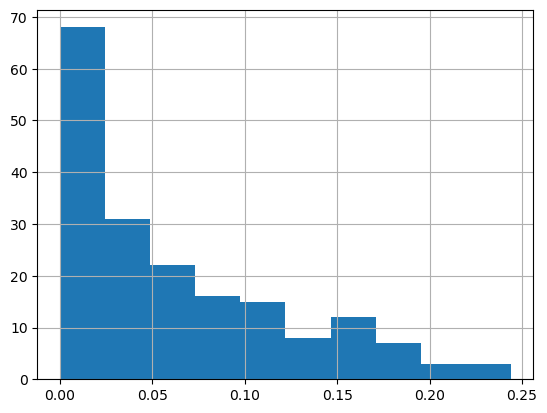

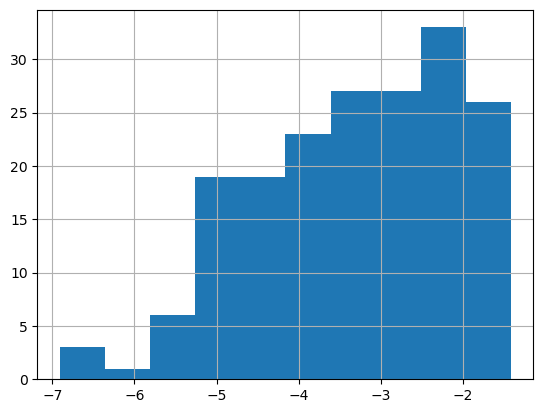

In [885]:
social_prot_expenditure.hist()
plt.subplots()
np.log(social_prot_expenditure[social_prot_expenditure > 0]).hist()

<Axes: >

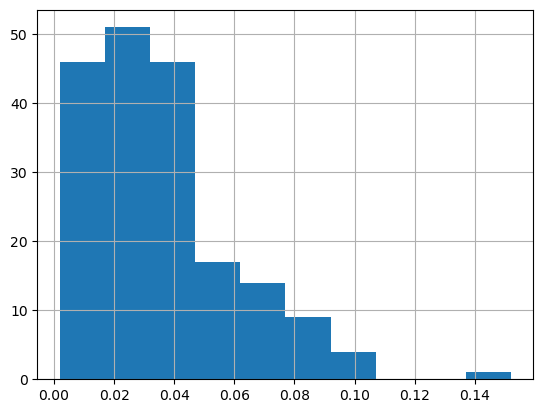

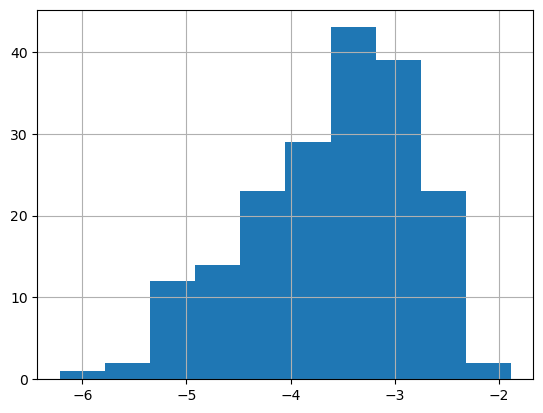

In [886]:
plt.subplots()
health_expenditure.hist()
plt.subplots()
np.log(health_expenditure[health_expenditure > 0]).hist()

In [887]:
pension_coverage = pd.read_excel("./inputs/social_share_regression/ILO/wcms_tableA4.2.xlsx", na_values='…').iloc[29:, [2, 15]]
pension_coverage.columns = ['iso3', 'ILO_pension_coverage']
pension_coverage.set_index('iso3', inplace=True)
pension_coverage.dropna(inplace=True)
pension_coverage = pension_coverage.astype(float) / 100

array([[<Axes: title={'center': 'ILO_pension_coverage'}>]], dtype=object)

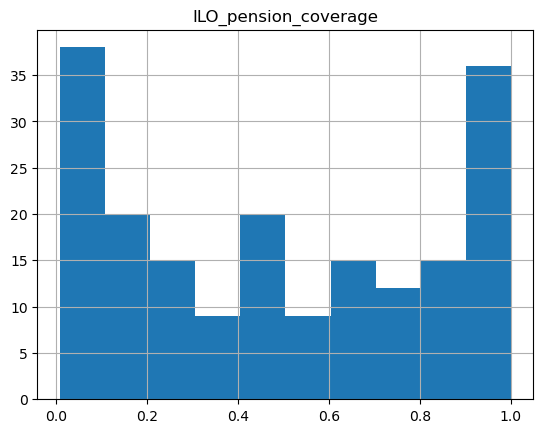

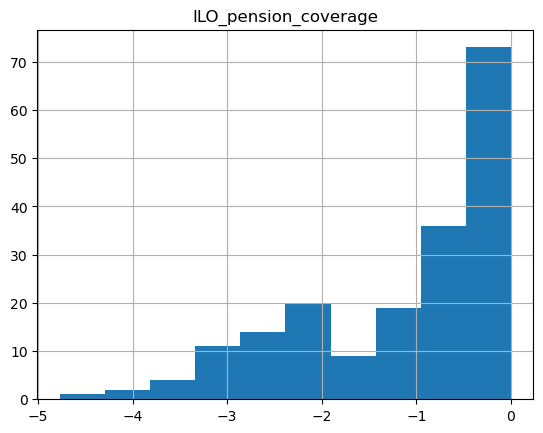

In [888]:
pension_coverage.hist()
np.log(pension_coverage[pension_coverage > 0]).hist()

In [889]:
social_prot_coverage = pd.read_excel("./inputs/social_share_regression/ILO/wcms_tableA4.2.xlsx", na_values='…').iloc[29:, [2, 7]]
social_prot_coverage.columns = ['iso3', 'ILO_social_coverage']
social_prot_coverage.set_index('iso3', inplace=True)
social_prot_coverage.dropna(inplace=True)
social_prot_coverage = social_prot_coverage.astype(float) / 100

array([[<Axes: title={'center': 'ILO_social_coverage'}>]], dtype=object)

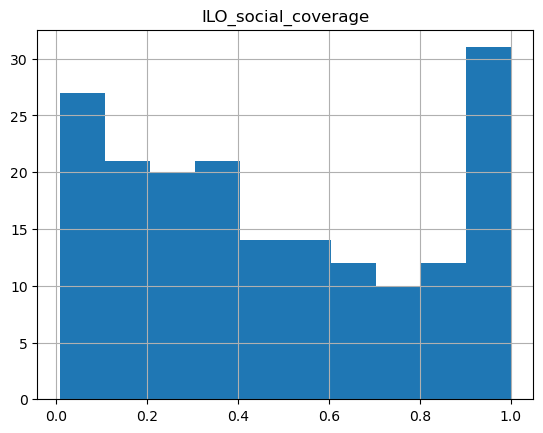

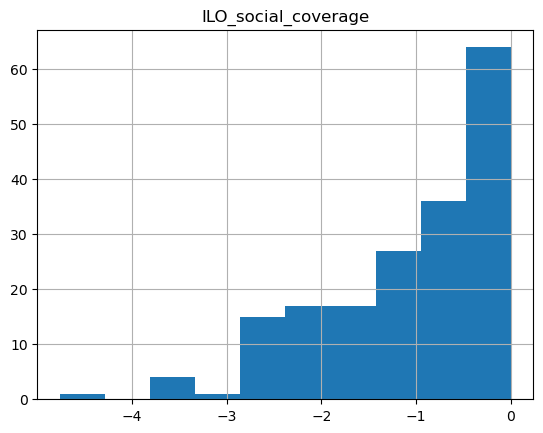

In [890]:
social_prot_coverage.hist()
np.log(social_prot_coverage[social_prot_coverage > 0]).hist()

In [891]:
health_coverage = pd.read_excel("./inputs/social_share_regression/ILO/wcms_tableA4.2.xlsx", na_values='…').iloc[29:, [2, 16]]
health_coverage.columns = ['iso3', 'ILO_health_coverage']
health_coverage.set_index('iso3', inplace=True)
health_coverage.dropna(inplace=True)
health_coverage = health_coverage.astype(float) / 100

array([[<Axes: title={'center': 'ILO_health_coverage'}>]], dtype=object)

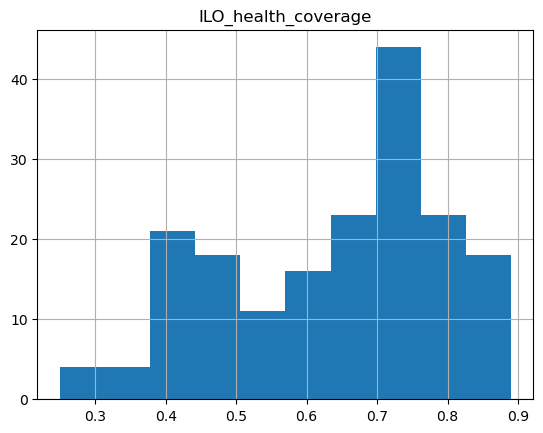

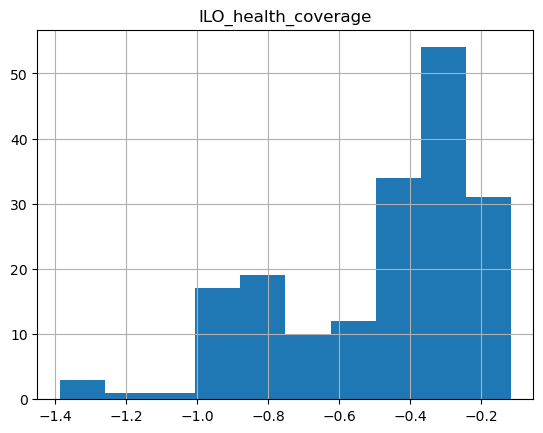

In [892]:
health_coverage.hist()
np.log(health_coverage[health_coverage > 0]).hist()

In [893]:
fsc = [
    'Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 
    'Lithuania', 'Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine','Uzbekistan'
]
former_yugoslavia = [
    'Bosnia and Herzegovina', 'Croatia', 'Kosovo', 'Montenegro', 'North Macedonia', 'Serbia', 
    'Slovenia'
]
former_socialist_countries = fsc + former_yugoslavia + [
    'Albania', 'Bulgaria', 'Czech Republic', 'Hungary', 'Poland', 'Romania', 'Slovakia'
]

fsr_old = [
    'Albania', 'Armenia', 'Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 'Estonia',
    'Georgia', 'Hungary', 'Kazakhstan', 'Kosovo', 'Kyrgyz Republic', 'Latvia', 'Lithuania', 'North Macedonia', 'Moldova',
    'Montenegro', 'Poland', 'Romania', 'Russian Federation', 'Serbia', 'Slovak Republic', 'Slovenia', 'Tajikistan',
    'Turkmenistan', 'Uzbekistan'
]

fsc = pd.DataFrame(
    index=pd.Index(former_socialist_countries, name='country'),
    data=True,
    columns=['FSR']
)
fsc = df_to_iso3(fsc.reset_index(), 'country', any_to_wb).set_index('iso3').drop('country', axis=1)
print(fsc)

       FSR
iso3      
ARM   True
AZE   True
BLR   True
EST   True
GEO   True
KAZ   True
KGZ   True
LVA   True
LTU   True
MDA   True
RUS   True
TJK   True
TKM   True
UKR   True
UZB   True
BIH   True
HRV   True
XKX   True
MNE   True
MKD   True
SRB   True
SVN   True
ALB   True
BGR   True
CZE   True
HUN   True
POL   True
ROU   True
SVK   True




###################
Correlation
###################
                               gdp_pc    GE_EST  remittances_gdp  gini_index  ILO_social_expenditure  ILO_health_expenditure  ILO_pension_coverage  \
gdp_pc                      1.000000  0.795978        -0.318261   -0.376548                0.548481                0.464048              0.597595   
GE_EST                      0.795978  1.000000        -0.293775   -0.354585                0.543311                0.563720              0.658067   
remittances_gdp            -0.318261 -0.293775         1.000000   -0.008366               -0.225684               -0.150060             -0.182921   
gini_index                 -0.376548 -0.354585        -0.008366    1.000000               -0.439948               -0.258629             -0.420842   
ILO_social_expenditure      0.548481  0.543311        -0.225684   -0.439948                1.000000                0.685756              0.704921   
ILO_health_expenditure      0.464048  0.563720     

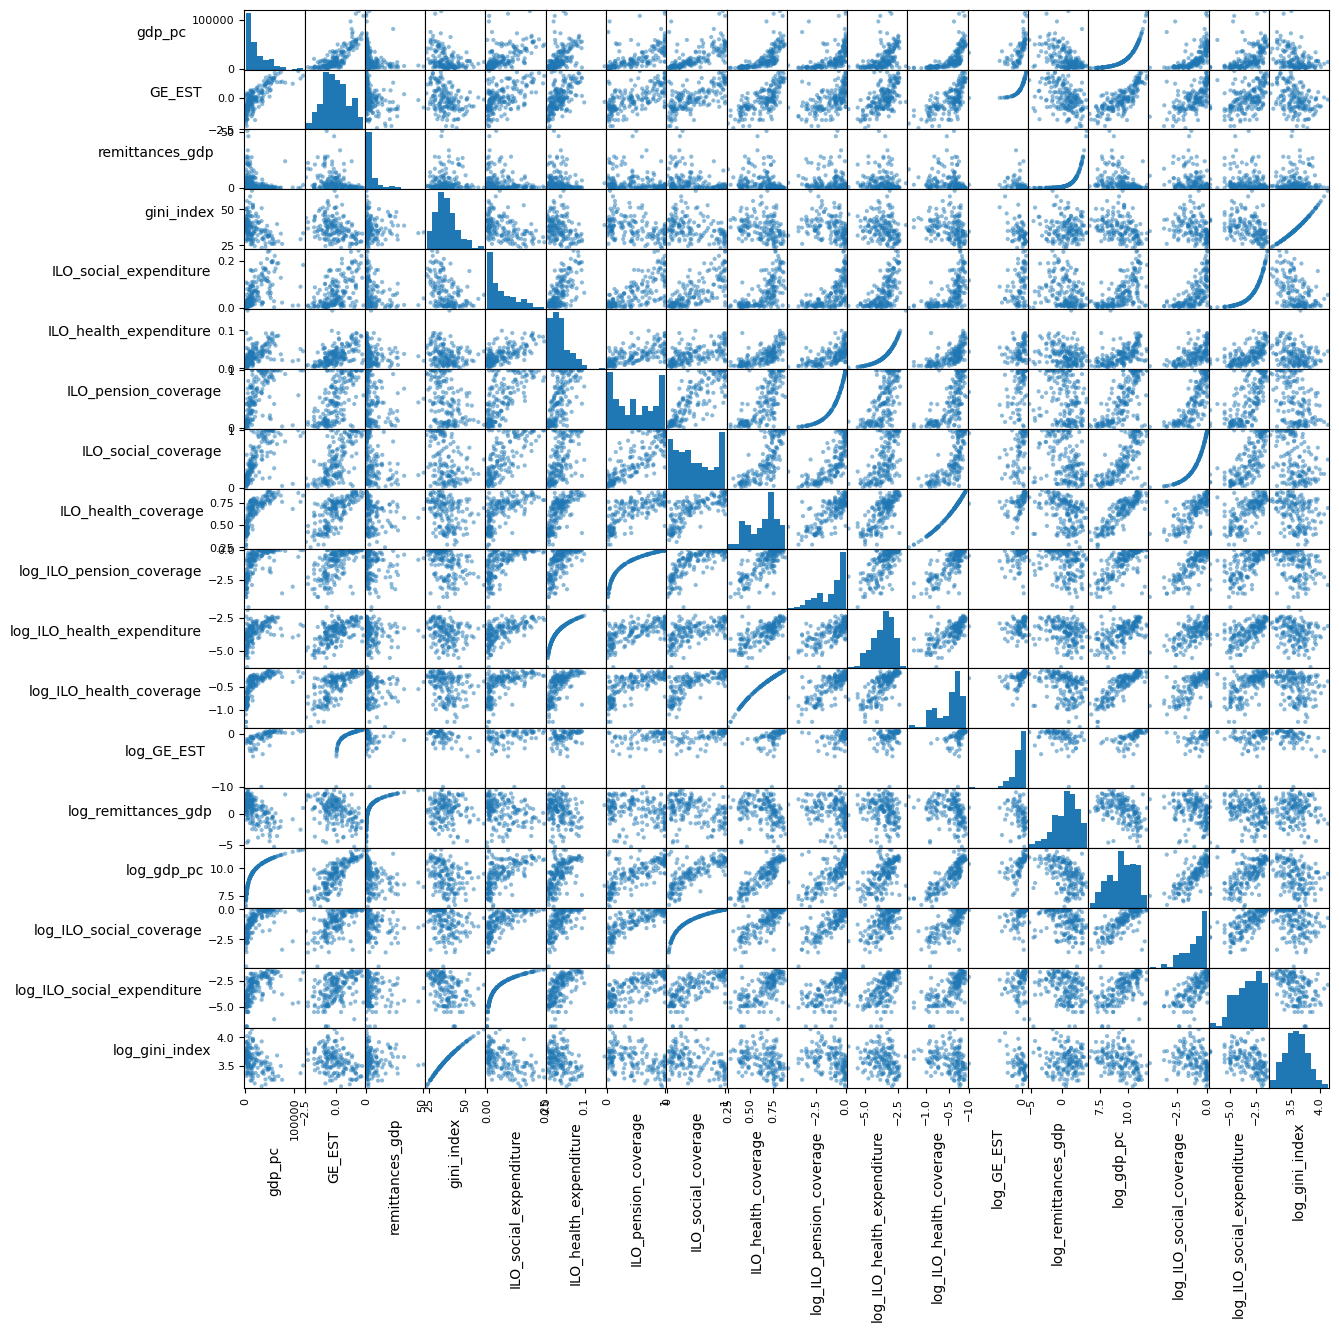

In [894]:
X = pd.concat([gdp_pc, gvt_effectiveness, remittances, wb_country_classification, gini_index, social_prot_expenditure, health_expenditure, pension_coverage, social_prot_coverage, health_coverage], axis=1)
X = pd.concat([X, fsc], axis=1)
X['FSR'] = X['FSR'].fillna(False).astype(int)
# X.dropna(inplace=True)
categorial_columns = list(wb_country_classification.columns) + ['FSR']
for c in list(set(X.columns) - set(categorial_columns)):
    X[f"log_{c}"] = np.log(X[c])
X = X.replace({np.inf: np.nan, -np.inf: np.nan})
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
axes = pd.plotting.scatter_matrix(X.drop(categorial_columns, axis=1), ax=ax)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
print("\n\n###################\nCorrelation\n###################\n", X.drop(categorial_columns, axis=1).corr())

In [895]:
_, Y_social_ = download_wb_data(root_dir=root_dir, include_remitances=True, use_additional_data=False, drop_incomplete=False)
Y_social_ = Y_social_.drop('axfin', axis=1)

loading file country_name_mappings/any_name_to_wb_name.csv from inputs
loading file country_name_mappings/iso3_to_wb_name.csv from inputs
loading file country_name_mappings/names_to_iso.csv from inputs
82 countries were not found in the world map. They will be excluded from the plot.
96 countries were not found in the world map. They will be excluded from the plot.
94 countries were not found in the world map. They will be excluded from the plot.
16 countries were not found in the world map. They will be excluded from the plot.
24 countries were not found in the world map. They will be excluded from the plot.
23 countries were not found in the world map. They will be excluded from the plot.
24 countries were not found in the world map. They will be excluded from the plot.
23 countries were not found in the world map. They will be excluded from the plot.
21 countries were not found in the world map. They will be excluded from the plot.
loading file FINDEX/findex_axfin.csv from inputs
7 

In [896]:
bottom_40 = Y_social_.drop(['q3', 'q4', 'q5'], level='income_cat').dropna()
bottom_40 = bottom_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / bottom_40.income_share.groupby('iso3').sum()
bottom_40.rename('social_bottom40', inplace=True)
top_60 = Y_social_.drop(['q1', 'q2'], level='income_cat').dropna()
top_60 = top_60[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_60.income_share.groupby('iso3').sum()
top_60.rename('social_top60', inplace=True)
top_40 = Y_social_.drop(['q1', 'q2'], level='income_cat').dropna()
top_40 = top_40[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_40.income_share.groupby('iso3').sum()
top_40.rename('social_top40', inplace=True)
top_80 = Y_social_.drop(['q1'], level='income_cat').dropna()
top_80 = top_80[['income_share', 'social']].product(axis=1).groupby('iso3').sum() / top_80.income_share.groupby('iso3').sum()
top_80.rename('social_top80', inplace=True)
print(bottom_40)
print(top_40)
print(top_60)
print(top_80)

iso3
AGO    0.151075
ALB    0.212207
ARG    0.239702
ARM    0.608379
AZE    0.020374
         ...   
XKX    0.263828
YEM    0.143651
ZAF    0.783326
ZMB    0.008404
ZWE    0.091104
Name: social_bottom40, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top40, Length: 101, dtype: float64
iso3
AGO    0.142823
ALB    0.164662
ARG    0.184092
ARM    0.288714
AZE    0.015340
         ...   
XKX    0.180454
YEM    0.087953
ZAF    0.310917
ZMB    0.005696
ZWE    0.120501
Name: social_top60, Length: 101, dtype: float64
iso3
AGO    0.144437
ALB    0.168613
ARG    0.186539
ARM    0.322655
AZE    0.015128
         ...   
XKX    0.187080
YEM    0.094069
ZAF    0.336115
ZMB    0.005915
ZWE    0.118471
Name: social_top80, Length: 101, dtype: float64


In [897]:
Y_social = Y_social_.unstack('income_cat')[['social']]
Y_social.columns = [f"{c[0]}_{c[1]}" for c in Y_social.columns]

In [898]:
adequacy_remittances = download_cat_info(name='adequacy_remittances', id_q1='per_pr_allpr.adq_q1_tot',
                                         id_q2='per_pr_allpr.adq_q2_tot', id_q3='per_pr_allpr.adq_q3_tot',
                                         id_q4='per_pr_allpr.adq_q4_tot', id_q5='per_pr_allpr.adq_q5_tot',
                                         most_recent_value=False, upper_bound=100, lower_bound=0) / 100
# Total transfer amount received by all beneficiaries in a population group as a share of the total welfare of
# beneficiaries in that group
adequacy_all_prot_lab = download_cat_info(name='adequacy_all_prot_lab', id_q1='per_allsp.adq_q1_tot',
                                          id_q2='per_allsp.adq_q2_tot', id_q3='per_allsp.adq_q3_tot',
                                          id_q4='per_allsp.adq_q4_tot', id_q5='per_allsp.adq_q5_tot',
                                          most_recent_value=False, upper_bound=100, lower_bound=0) / 100
# Coverage
coverage_remittances = download_cat_info(name='coverage_remittances', id_q1='per_pr_allpr.cov_q1_tot',
                                         id_q2='per_pr_allpr.cov_q2_tot', id_q3='per_pr_allpr.cov_q3_tot',
                                         id_q4='per_pr_allpr.cov_q4_tot', id_q5='per_pr_allpr.cov_q5_tot',
                                         most_recent_value=False, upper_bound=100, lower_bound=0) / 100
coverage_all_prot_lab = download_cat_info(name='coverage_all_prot_lab', id_q1='per_allsp.cov_q1_tot',
                                          id_q2='per_allsp.cov_q2_tot', id_q3='per_allsp.cov_q3_tot',
                                          id_q4='per_allsp.cov_q4_tot', id_q5='per_allsp.cov_q5_tot',
                                          most_recent_value=False, upper_bound=100, lower_bound=0) / 100
Y_aspire_raw = pd.concat([adequacy_remittances, adequacy_all_prot_lab, coverage_remittances, coverage_all_prot_lab], axis=1).dropna().reset_index()
Y_aspire_raw = df_to_iso3(Y_aspire_raw, 'country', any_to_wb).dropna(subset='iso3').drop('country', axis=1)
Y_aspire_raw = Y_aspire_raw.loc[Y_aspire_raw.groupby(['iso3', 'income_cat']).year.idxmax()].set_index(['iso3', 'income_cat']).drop('year', axis=1)
Y_aspire_raw = Y_aspire_raw.unstack('income_cat')
Y_aspire_raw.columns = [f"{c[0]}_{c[1]}" for c in Y_aspire_raw.columns]

In [899]:
Y = pd.concat([Y_social, bottom_40, top_40, top_60, top_80, Y_aspire_raw], axis=1).dropna(how='all')
print(Y)

      social_q1  social_q2  social_q3  social_q4  social_q5  social_bottom40  social_top40  social_top60  social_top80  adequacy_remittances_q1  \
iso3                                                                                                                                              
AFG    0.111074   0.082602   0.073095   0.047391   0.029296              NaN           NaN           NaN           NaN                 0.405225   
ALB    0.243888   0.192046   0.178422   0.182160   0.147807         0.212207      0.164662      0.164662      0.168613                 0.160785   
AGO    0.126905   0.163002   0.134731   0.155588   0.139974         0.151075      0.142823      0.142823      0.144437                 0.379655   
ARG    0.302076   0.207570   0.189000   0.188540   0.180409         0.239702      0.184092      0.184092      0.186539                 0.231837   
ARM    0.750543   0.511542   0.444049   0.363883   0.173967         0.608379      0.288714      0.288714      0.322655

In [900]:
regression_data = pd.concat([X, Y], axis=1).loc[Y.index]
print(regression_data)

            gdp_pc    GE_EST  remittances_gdp                      region         income_group Latin_America_Caribbean South_Asia  \
iso3                                                                                                                                
AFG    1516.273265 -1.879552         2.102828                  South Asia           Low income                   False       True   
ALB   15492.067404  0.065063         9.226106       Europe & Central Asia  Upper middle income                   False      False   
AGO    5906.115677 -1.040429         0.013116          Sub-Saharan Africa  Lower middle income                   False      False   
ARG   22461.440943 -0.282877         0.200821   Latin America & Caribbean  Upper middle income                    True      False   
ARM   16057.006457 -0.314230        10.427740       Europe & Central Asia  Upper middle income                   False      False   
...            ...       ...              ...                        

# Regression 'social'

In [901]:
target_variables = Y.columns
selected_formulas = {
    'original_social_q1': '{} ~ log_ILO_social_expenditure + GE_EST + FSR',
    'original_social_top80': '{} ~ ILO_social_expenditure + GE_EST + FSR',
}

In [902]:
def run_regressions(formulas_, target_variable_, verbose=True):
    regression_results = pd.DataFrame(
        columns=['R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
        index=[i + 1 for i in range(len(formulas_))]
    )
    for formula_nr, formula in enumerate(formulas_):
        if verbose:
            print(f"\n\n\n###############################\nRegression for {target_variable_}\n###############################\n")
            print(f"++++++ formula {formula_nr + 1}: {formula} ++++++")
        features = [f for f in formula.split(' ~ ')[1].split(' + ') if f not in categorial_columns]
        if len(features) > 1 and verbose:
            vif_data = pd.DataFrame(
                columns=['VIF'],
                index=features,
                data=[variance_inflation_factor(X[features].dropna().values, i) for i in range(len(features))]
            )
            print(vif_data)
        model = smf.ols(formula=formula.format(target_variable_.replace('_first_try', '').replace('original_', '')), data=regression_data, missing='drop')
        regression = model.fit()
        if verbose:
            print(regression.summary())
        regression_results.loc[formula_nr + 1] = [regression.rsquared, regression.rsquared_adj, regression.aic, regression.bic, regression.fvalue, regression.f_pvalue]
    return regression_results

## Q1

In [903]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR',
    # '{} ~ ILO_social_expenditure + GE_EST + FSR',
]
target_variable = target_variables[0]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_q1
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q1   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     9.326
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           2.95e-11
Time:                        17:12:03   Log-Likelihood:                 54.171
No. Observations:                  99   AIC:                            -82.34
Df Residuals:                      86   BIC:                            -48.60
Df Model:

## Q1 new

In [904]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage +'
    ' ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ log_ILO_social_expenditure + remittances_gdp + FSR + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + ILO_social_coverage + ILO_health_expenditure',
]
target_variable = target_variables[0]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q1
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:              social_q1   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     8.265
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           7.42e-11
Time:                        17:12:03 

## Q2

In [905]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Low_income + Lower_middle_income',
    # '{} ~ ILO_social_expenditure + FSR + Low_income + Lower_middle_income',
]
target_variable = target_variables[1]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_q2
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q2   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     7.642
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           1.96e-09
Time:                        17:12:03   Log-Likelihood:                 70.485
No. Observations:                  99   AIC:                            -115.0
Df Residuals:                      86   BIC:                            -81.23
Df Model:

## Q2 new


In [906]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + Lower_middle_income + Upper_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + Upper_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + Latin_America_Caribbean + Upper_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + Latin_America_Caribbean + Upper_middle_income + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + Upper_middle_income + ILO_social_coverage + ILO_health_expenditure',
]
target_variable = target_variables[1]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q2
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:              social_q2   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     7.555
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           4.76e-10
Time:                        17:12:03 

## Q3

In [907]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social_expenditure + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social_expenditure + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
target_variable = target_variables[2]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_q3
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q3   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     6.686
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           2.51e-08
Time:                        17:12:03   Log-Likelihood:                 76.579
No. Observations:                  99   AIC:                            -127.2
Df Residuals:                      86   BIC:                            -93.42
Df Model:

## Q3 new

In [908]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_social_coverage',
]
target_variable = target_variables[2]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q3
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:              social_q3   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     7.155
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           1.41e-09
Time:                        17:12:03 

## Q4

In [909]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social_expenditure + remittances_gdp + income_group + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social_expenditure + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa + Low_income + Lower_middle_income',
    '{} ~ ILO_social_expenditure + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income',
]
target_variable = target_variables[3]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_q4
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q4   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     5.554
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           6.09e-07
Time:                        17:12:03   Log-Likelihood:                 83.841
No. Observations:                  99   AIC:                            -141.7
Df Residuals:                      86   BIC:                            -107.9
Df Model:

## Q4 new

In [910]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Lower_middle_income + ILO_social_coverage + ILO_health_coverage',
]
target_variable = target_variables[3]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q4
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:              social_q4   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     6.288
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           1.64e-08
Time:                        17:12:03 

## Q5

In [911]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social_expenditure + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ log_ILO_social_expenditure + log_remittances_gdp + region',
    '{} ~ log_ILO_social_expenditure + log_remittances_gdp + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social_expenditure + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ log_ILO_social_expenditure + Middle_East_North_Africa + Sub_Saharan_Africa',
]
target_variable = target_variables[4]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_q5
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:              social_q5   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     3.625
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           0.000211
Time:                        17:12:03   Log-Likelihood:                 102.96
No. Observations:                  99   AIC:                            -179.9
Df Residuals:                      86   BIC:                            -146.2
Df Model:

## Q5 new

In [912]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + FSR + region + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + region + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + ILO_social_coverage + ILO_health_coverage',
]
target_variable = target_variables[4]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_q5
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:              social_q5   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     3.554
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           0.000104
Time:                        17:12:03 

## Bottom 40%

In [913]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + Low_income + Lower_middle_income',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Low_income + Lower_middle_income',
]
target_variable = target_variables[5]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_bottom40
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:        social_bottom40   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     8.251
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           6.49e-10
Time:                        17:12:03   Log-Likelihood:                 62.963
No. Observations:                  94   AIC:                            -99.93
Df Residuals:                      81   BIC:                            -66.86
Df 

## Bottom 40% new

In [914]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + Latin_America_Caribbean + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + remittances_gdp + FSR + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + ILO_pension_coverage + ILO_social_coverage + ILO_health_expenditure',
    '{} ~ remittances_gdp + FSR + ILO_social_coverage + ILO_health_expenditure',
]
target_variable = target_variables[5]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_bottom40
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:        social_bottom40   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     8.213
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           1.31e-10
Time:                        17:

## Top 40%

In [915]:
formulas = [
    '{} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group',
    '{} ~ log_ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group',
    '{} ~ ILO_social_expenditure + GE_EST + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social_expenditure + log_remittances_gdp + region + income_group',
    '{} ~ ILO_social_expenditure + log_remittances_gdp + region + Lower_middle_income + Low_income',
    '{} ~ ILO_social_expenditure + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa + Sub_Saharan_Africa',
    '{} ~ ILO_social_expenditure + log_remittances_gdp + Lower_middle_income + Low_income + Latin_America_Caribbean + Middle_East_North_Africa',
    '{} ~ ILO_social_expenditure + log_remittances_gdp + Lower_middle_income + Low_income + Middle_East_North_Africa',
]
target_variable = target_variables[6]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable + '_first_try'] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ log_ILO_social_expenditure + GE_EST + log_remittances_gdp + FSR + region + income_group ++++++
                                 VIF
log_ILO_social_expenditure  1.100614
GE_EST                      1.182505
log_remittances_gdp         1.261266
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     5.467
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           9.97e-07
Time:                        17:12:04   Log-Likelihood:                 92.361
No. Observations:                  94   AIC:                            -158.7
Df Residuals:                      81   BIC:                            -125.7
Df Mod

## Top 40% new

In [916]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
    '{} ~ GE_EST + remittances_gdp + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Sub_Saharan_Africa + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ GE_EST + remittances_gdp + Latin_America_Caribbean + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Lower_middle_income + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + Lower_middle_income + ILO_social_coverage + ILO_health_coverage',
    '{} ~ remittances_gdp + Latin_America_Caribbean + ILO_social_coverage + ILO_health_coverage',
]
target_variable = target_variables[6]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_top40
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:           social_top40   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     5.298
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           4.12e-07
Time:                        17:12:

# Regression 'adequacy_remittances'

NOTE: The following regressions are not refined, but only used as an indicator of the maximum R2 that can be achieved for individual ASPIRE indicators. 

## Q1

In [917]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[8]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for social_top80
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                            OLS Regression Results                            
Dep. Variable:           social_top80   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     5.935
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           6.13e-08
Time:                        17:12:

## Q2

In [918]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[9]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q1
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q1   R-squared:                       0.197
Model:                                 OLS   Adj. R-squared:                  0.024
Method:                      Least Squares   F-statistic:                     1.138
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):              0.338

## Q3

In [919]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[10]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q2
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q2   R-squared:                       0.300
Model:                                 OLS   Adj. R-squared:                  0.151
Method:                      Least Squares   F-statistic:                     2.010
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):             0.0230

## Q4

In [920]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[11]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q3
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q3   R-squared:                       0.332
Model:                                 OLS   Adj. R-squared:                  0.192
Method:                      Least Squares   F-statistic:                     2.364
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):            0.00657

## Q5

In [921]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[12]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q4
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q4   R-squared:                       0.376
Model:                                 OLS   Adj. R-squared:                  0.243
Method:                      Least Squares   F-statistic:                     2.824
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):            0.00130

# Regression 'adequacy_all_prot_lab'

## Q1

In [922]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[13]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_remittances_q5
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     adequacy_remittances_q5   R-squared:                       0.340
Model:                                 OLS   Adj. R-squared:                  0.200
Method:                      Least Squares   F-statistic:                     2.419
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):            0.00550

## Q2

In [923]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[14]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q1
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q1   R-squared:                       0.391
Model:                                  OLS   Adj. R-squared:                  0.260
Method:                       Least Squares   F-statistic:                     2.971
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           0.

## Q3

In [924]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[15]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q2
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q2   R-squared:                       0.354
Model:                                  OLS   Adj. R-squared:                  0.217
Method:                       Least Squares   F-statistic:                     2.574
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):            0

## Q4

In [925]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[16]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q3
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q3   R-squared:                       0.455
Model:                                  OLS   Adj. R-squared:                  0.340
Method:                       Least Squares   F-statistic:                     3.967
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           2.

## Q5

In [926]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[17]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q4
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q4   R-squared:                       0.398
Model:                                  OLS   Adj. R-squared:                  0.269
Method:                       Least Squares   F-statistic:                     3.094
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           0.

# Regression 'coverage_remittances'

## Q1

In [927]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[18]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for adequacy_all_prot_lab_q5
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     adequacy_all_prot_lab_q5   R-squared:                       0.294
Model:                                  OLS   Adj. R-squared:                  0.143
Method:                       Least Squares   F-statistic:                     1.951
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):             

## Q2

In [928]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[19]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q1
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q1   R-squared:                       0.340
Model:                                 OLS   Adj. R-squared:                  0.197
Method:                      Least Squares   F-statistic:                     2.383
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):            0.00633

## Q3

In [929]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[20]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q2
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q2   R-squared:                       0.322
Model:                                 OLS   Adj. R-squared:                  0.178
Method:                      Least Squares   F-statistic:                     2.231
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):             0.0107

## Q4

In [930]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[21]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q3
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q3   R-squared:                       0.283
Model:                                 OLS   Adj. R-squared:                  0.132
Method:                      Least Squares   F-statistic:                     1.876
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):             0.0361

## Q5

In [931]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[22]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q4
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q4   R-squared:                       0.277
Model:                                 OLS   Adj. R-squared:                  0.122
Method:                      Least Squares   F-statistic:                     1.792
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):             0.0480

# Regression 'coverage_all_prot_lab'

## Q1

In [932]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[23]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_remittances_q5
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                              
Dep. Variable:     coverage_remittances_q5   R-squared:                       0.291
Model:                                 OLS   Adj. R-squared:                  0.140
Method:                      Least Squares   F-statistic:                     1.926
Date:                     Fri, 15 Mar 2024   Prob (F-statistic):             0.0307

## Q2

In [933]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[24]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q1
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q1   R-squared:                       0.624
Model:                                  OLS   Adj. R-squared:                  0.543
Method:                       Least Squares   F-statistic:                     7.681
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           2.

## Q3

In [934]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[25]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q2
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q2   R-squared:                       0.608
Model:                                  OLS   Adj. R-squared:                  0.524
Method:                       Least Squares   F-statistic:                     7.269
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           8.

## Q4

In [935]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[26]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q3
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q3   R-squared:                       0.583
Model:                                  OLS   Adj. R-squared:                  0.495
Method:                       Least Squares   F-statistic:                     6.642
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           4.

## Q5

In [936]:
formulas = [
    '{} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure',
]
target_variable = target_variables[27]
print("\n\n", run_regressions(formulas, target_variable))
selected_formulas[target_variable] = formulas[-1]




###############################
Regression for coverage_all_prot_lab_q4
###############################

++++++ formula 1: {} ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR + region + income_group + ILO_pension_coverage + ILO_social_coverage + ILO_health_coverage + ILO_health_expenditure ++++++
                              VIF
ILO_social_expenditure   8.132060
GE_EST                   2.070350
remittances_gdp          1.647757
ILO_pension_coverage    14.777877
ILO_social_coverage     15.745530
ILO_health_coverage     13.253089
ILO_health_expenditure  10.156034
                               OLS Regression Results                               
Dep. Variable:     coverage_all_prot_lab_q4   R-squared:                       0.576
Model:                                  OLS   Adj. R-squared:                  0.485
Method:                       Least Squares   F-statistic:                     6.361
Date:                      Fri, 15 Mar 2024   Prob (F-statistic):           1.

In [937]:
result = pd.DataFrame(
    columns=['formula', 'R2', 'Adj. R2', 'AIC', 'BIC', 'F-statistic', 'Prob(F-statistic)'],
    index=list(selected_formulas.keys()),
    data=[[selected_formulas[i], *run_regressions([selected_formulas[i]], i, verbose=False).iloc[0]] for i in list(selected_formulas.keys())]
)
print(result.sort_values(by='R2'))

                                                                     formula        R2   Adj. R2         AIC         BIC  F-statistic  \
adequacy_remittances_q1    {} ~ ILO_social_expenditure + GE_EST + remitta...  0.197487  0.023971  -41.415092    1.269519     1.138149   
social_q5_first_try        {} ~ log_ILO_social_expenditure + Middle_East_...  0.270701  0.248146 -193.429805 -182.969323    12.001504   
coverage_remittances_q4    {} ~ ILO_social_expenditure + GE_EST + remitta...  0.276607  0.122283  -22.338817   20.531589     1.792381   
coverage_remittances_q3    {} ~ ILO_social_expenditure + GE_EST + remitta...  0.283099  0.132173  -22.111289   20.942903     1.875745   
coverage_remittances_q5    {} ~ ILO_social_expenditure + GE_EST + remitta...  0.291193  0.139980  -26.794766   16.075639     1.925722   
adequacy_all_prot_lab_q5   {} ~ ILO_social_expenditure + GE_EST + remitta...  0.293893  0.143257  -85.506218  -42.635812     1.951017   
adequacy_remittances_q2    {} ~ ILO_socia

# Prediction

In [952]:
def predict_social(formula, data, target_variable_):
    model = smf.ols(formula=formula.format(target_variable_.replace('original_', '').replace('_first_try', '')), data=regression_data, missing='drop')
    regression = model.fit()
    return regression.predict(data)

## prediciton with original formulas

In [953]:
pred_formulas = {
    'q1': 'original_social_q1',
    'q2': 'original_social_top80',
    'q3': 'original_social_top80',
    'q4': 'original_social_top80',
    'q5': 'original_social_top80',
}
for k, v in pred_formulas.items():
    print(f"{k}:", result.loc[v, 'formula'].format(v))

q1: original_social_q1 ~ log_ILO_social_expenditure + GE_EST + FSR
q2: original_social_top80 ~ ILO_social_expenditure + GE_EST + FSR
q3: original_social_top80 ~ ILO_social_expenditure + GE_EST + FSR
q4: original_social_top80 ~ ILO_social_expenditure + GE_EST + FSR
q5: original_social_top80 ~ ILO_social_expenditure + GE_EST + FSR


In [954]:
social_predicted = pd.concat([predict_social(result.loc[pred_formulas[q], 'formula'], X, target_var).rename(q) for q, target_var in pred_formulas.items()], axis=1)
social_predicted.columns.name = 'income_cat'
social_predicted = social_predicted.stack('income_cat').rename('social')
social_predicted

iso3  income_cat
AFG   q1            0.087168
      q2            0.067488
      q3            0.067488
      q4            0.067488
      q5            0.067488
                      ...   
YEM   q1            0.013763
      q2            0.045425
      q3            0.045425
      q4            0.045425
      q5            0.045425
Name: social, Length: 914, dtype: float64

In [955]:
social_predicted.to_csv("./inputs/social_share_regression/social_predicted_original_formulas.csv", header=True)

## first try

In [956]:
pred_formulas = {
    'q1': 'social_q1_first_try',
    'q2': 'social_q2_first_try',
    'q3': 'social_q3_first_try',
    'q4': 'social_q4_first_try',
    'q5': 'social_q5_first_try',
}
for k, v in pred_formulas.items():
    print(f"{k}:", result.loc[v, 'formula'].format(v))

q1: social_q1_first_try ~ ILO_social_expenditure + GE_EST + remittances_gdp + FSR
q2: social_q2_first_try ~ ILO_social_expenditure + remittances_gdp + FSR + Low_income + Lower_middle_income
q3: social_q3_first_try ~ ILO_social_expenditure + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income
q4: social_q4_first_try ~ ILO_social_expenditure + remittances_gdp + Latin_America_Caribbean + Middle_East_North_Africa + Low_income + Lower_middle_income
q5: social_q5_first_try ~ log_ILO_social_expenditure + Middle_East_North_Africa + Sub_Saharan_Africa


In [957]:
social_predicted = pd.concat([predict_social(result.loc[pred_formulas[q], 'formula'], X, target_var).rename(q) for q, target_var in pred_formulas.items()], axis=1)
social_predicted.columns.name = 'income_cat'
social_predicted = social_predicted.stack('income_cat').rename('social')
social_predicted

iso3  income_cat
AFG   q1            0.029919
      q2            0.057579
      q3            0.074791
      q4            0.072520
      q5            0.147360
                      ...   
YEM   q2            0.094786
      q3            0.028485
      q4            0.031734
      q5            0.061497
TWN   q5            0.175464
Name: social, Length: 891, dtype: float64

In [958]:
social_predicted.to_csv("./inputs/social_share_regression/social_predicted_first_try.csv", header=True)

## new

In [959]:
pred_formulas = {
    'q1': 'social_q1',
    'q2': 'social_q2',
    'q3': 'social_q3',
    'q4': 'social_top40',
    'q5': 'social_top40',
}
for k, v in pred_formulas.items():
    print(f"{k}:", result.loc[v, 'formula'].format(v))

q1: social_q1 ~ remittances_gdp + FSR + ILO_social_coverage + ILO_health_expenditure
q2: social_q2 ~ remittances_gdp + FSR + Upper_middle_income + ILO_social_coverage + ILO_health_expenditure
q3: social_q3 ~ remittances_gdp + Latin_America_Caribbean + Low_income + Lower_middle_income + ILO_social_coverage
q4: social_top40 ~ remittances_gdp + Latin_America_Caribbean + ILO_social_coverage + ILO_health_coverage
q5: social_top40 ~ remittances_gdp + Latin_America_Caribbean + ILO_social_coverage + ILO_health_coverage


In [960]:
social_predicted = pd.concat([predict_social(result.loc[pred_formulas[q], 'formula'], X, target_var).rename(q) for q, target_var in pred_formulas.items()], axis=1)
social_predicted.columns.name = 'income_cat'
social_predicted = social_predicted.stack('income_cat').rename('social')
social_predicted

iso3  income_cat
AFG   q1            0.034225
      q2            0.032845
      q3            0.035930
      q4            0.021533
      q5            0.021533
                      ...   
SSD   q4            0.046506
      q5            0.046506
YEM   q3            0.095270
      q4            0.090487
      q5            0.090487
Name: social, Length: 797, dtype: float64

In [961]:
social_predicted.to_csv("./inputs/social_share_regression/social_predicted.csv", header=True)